In [1]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt

In [2]:
tmax = 50
T = np.linspace(0, tmax, 1000)

In [19]:
# Model hyper parameters
xbar = 10
delta_x = 5
lamb = 0.1

sigma_x = 0.1
mu0 = 0.1
nu0 = 0.0
D = 1e-6
tau = 10
sigma_y = 0.01

In [9]:
# growth rate

m = mu0 + nu0 * T

def pairwise_min(x):
    assert len(x.shape) == 1
    x1 = np.einsum('i,j->ij', x, np.ones_like(x))
    x2 = np.einsum('i,j->ji', x, np.ones_like(x))
    x12 = np.concatenate([[x1], [x2]])
    return np.min(x12, axis=0)

def pairwise_max(x):
    assert len(x.shape) == 1
    x1 = np.einsum('i,j->ij', x, np.ones_like(x))
    x2 = np.einsum('i,j->ji', x, np.ones_like(x))
    x12 = np.concatenate([[x1], [x2]])
    return np.max(x12, axis=0)

def pairwise_distance(x):
    assert len(x.shape) == 1
    x1 = np.einsum('i,j->ij', x, np.ones_like(x))
    x2 = np.einsum('i,j->ji', x, np.ones_like(x))
    return np.abs(x1 - x2)

minT = pairwise_min(T)
maxT = pairwise_max(T)
distT = pairwise_distance(T)
Sigma_intBM = D * minT**2 / float(2) * (maxT - minT / float(3))
Sigma_sqExp = sigma_y**2 * np.exp(- distT**2 / float(2 * tau**2))
Sigma = Sigma_intBM + Sigma_sqExp

mu = multivariate_normal.rvs(mean=m, cov=Sigma)

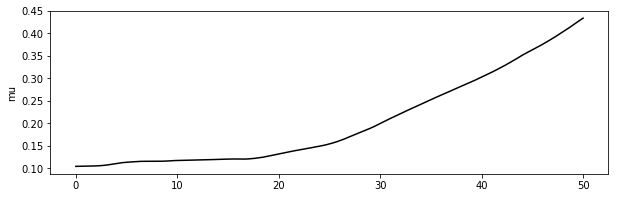

In [10]:
plt.figure(figsize=(10, 3))
plt.plot(T, mu, 'k-')
plt.ylabel('mu')
plt.show()

In [16]:
# True noiseless log-OD

x_low = 1
x_high = 2

x_noiseless = [x_low]
dt = T[1] - T[0]
for t_idx in range(1,len(T)):
    x0 = x_noiseless[t_idx - 1] if x_noiseless[t_idx - 1] < x_high else x_low
    xt = x0 + (mu[t_idx - 1] + mu[t_idx]) / 2 * dt
    x_noiseless.append(xt)
x_noiseless = np.array(x_noiseless)

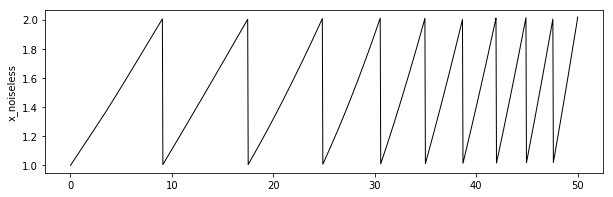

In [17]:
plt.figure(figsize=(10, 3))
plt.plot(T, x_noiseless, 'k-', lw=1)
plt.ylabel('x_noiseless')
plt.show()

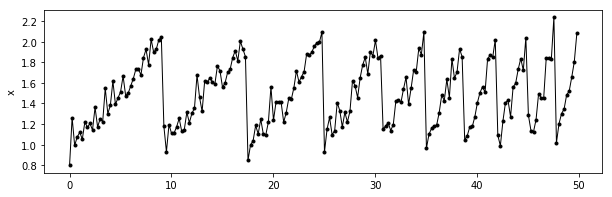

In [24]:
# Observed log-OD
measured_indexes = np.array(range(0, 1000, 5)).astype(int)
t = T[measured_indexes]

x = multivariate_normal.rvs(mean=x_noiseless[measured_indexes], 
                            cov=np.eye(len(measured_indexes)) * sigma_x**2)
plt.figure(figsize=(10, 3))
plt.plot(t, x, 'k.-', lw=1)
plt.ylabel('x')
plt.show()

In [41]:
mu = multivariate_normal.rvs(mean=m, cov=Sigma)

x_noiseless = [x_low]
dt = T[1] - T[0]
for t_idx in range(1,len(T)):
    x0 = x_noiseless[t_idx - 1] if x_noiseless[t_idx - 1] < x_high else x_low
    xt = x0 + (mu[t_idx - 1] + mu[t_idx]) / 2 * dt
    x_noiseless.append(xt)
x_noiseless = np.array(x_noiseless)

x = multivariate_normal.rvs(mean=x_noiseless[measured_indexes], 
                            cov=np.eye(len(measured_indexes)) * sigma_x**2)


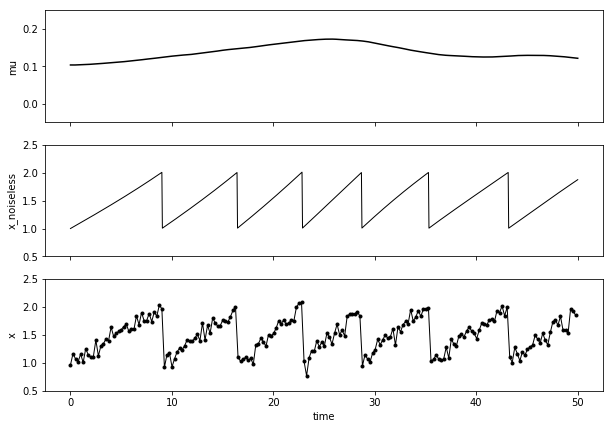

In [53]:
fig, axes = plt.subplots(3,1, figsize=(10, 7), sharex=True)

ax =  axes[0]
ax.plot(T, mu, 'k-')
ax.set_ylabel('mu')
ax.set_ylim([-0.05, 0.25])

ax =  axes[1]
ax.plot(T, x_noiseless, 'k-', lw=1)
ax.set_ylabel('x_noiseless')
ax.set_ylim([0.5, 2.5])

ax = axes[2]
ax.plot(t, x, 'k.-', lw=1)
ax.set_ylabel('x')
ax.set_ylim([0.5, 2.5])

ax.set_xlabel('time')

plt.savefig('../latex/figs/data.pdf', bbox_inches='tight')
plt.show()

In [54]:
output_file = 'data.tsv'
with open(output_file, 'w') as fout:
    header = ['t', 'x', 'x_noiseless', 'mu']
    fout.write('\t'.join(header) + '\n')
    for ti, xi, xnli, mui in zip(t, x, x_noiseless[measured_indexes], mu[measured_indexes]):
        record = [ti, xi, xnli, mui]
        fout.write('\t'.join(map(str, record)) + '\n')